# Big Data Assignment 3

## Building an ETL Pipeline with Apache Airflow

### Madison E. Chester

##### Objective 

The goal of this assignment includes building an ETL pipeline using Apache Airflow that processes and prepares data for a machine learning model. The dataset to be used is the UCI Machine Learning Repository’s “Online Retail” dataset, which contains transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. 

**This PDF solely functions to explain the process and theory behind implementations. The code should not be executed. The README file includes all necessary information to replicate outcomes.**

##### ETL Pipeline 

Necessary Imports

In [ ]:
# for the dag
from airflow import DAG
from airflow.models import Variable
from airflow.operators.python import PythonOperator
from airflow.operators.email_operator import EmailOperator

import pandas as pd
from pymongo import MongoClient 
from ucimlrepo import fetch_ucirepo 
from datetime import datetime, timedelta

In [ ]:
# for this file
from PIL import Image
from IPython.display import display

##### download_dataset

This function downloads the data from the provided URL and saves the file to a csv in a temporary folder. 

XCom is a feature that allows tasks to exchange messages or small amounts of data. This provides a simple way for tasks within a workflow to communicate with one another. 

In [ ]:
def download_dataset(**kwargs):
    # fetch dataset 
    online_retail = fetch_ucirepo(id=352) 
    df = online_retail.data.original
    print(df.shape)

    # save dataframe to a csv file
    file_path = '/tmp/online_retail.csv'
    df.to_csv(file_path, index=False)

    # push the file path to xcom
    kwargs['ti'].xcom_push(key='file_path', value=file_path)

##### data_cleaning

This function...

- reads the data from the previous step.

- converts the 'InvoiceDate' column to a datetime type.

- drops the duplicate and null rows.

- pushes the data back to the temporary folder.

In [ ]:
def data_cleaning(**kwargs):
    # pull the file path from xcom
    ti = kwargs['ti']
    file_path = ti.xcom_pull(key='file_path', task_ids='download_dataset')
    
    # read the dataframe from the csv file
    df = pd.read_csv(file_path)
    print(df.shape)

    # clean data
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df.dropna(inplace = True)
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True, drop=True)

    # save the processed dataframe back to the csv file
    file_path = '/tmp/online_retail.csv'
    df.to_csv(file_path, index=False)
    
    # push the processed file path back to xcom
    ti.xcom_push(key='file_path', value=file_path)

##### data_transformation

This function creates a new column 'TotalPrice' that is the product of 'Quantity' and 'UnitPrice'.

In [ ]:
def data_transformation(**kwargs):
    # pull the file path from xcom
    ti = kwargs['ti']
    file_path = ti.xcom_pull(key='file_path', task_ids='data_cleaning')
    
    # read the dataframe from the csv file
    df = pd.read_csv(file_path)
    print(df.shape)

    # create the new column
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

    # save the transformed dataframe back to the csv file
    file_path = '/tmp/online_retail.csv'
    df.to_csv(file_path, index=False)
    
    # push the transformed file path back to XCom
    ti.xcom_push(key='file_path', value=file_path)

##### data_to_nosql

This task loads the transformed data to the MongoDB collection titled 'retail'. The data is stored as a dictionary.

In [ ]:
def data_to_nosql(**kwargs):
    # pull the file path from XCom
    ti = kwargs['ti']
    file_path = ti.xcom_pull(key='file_path', task_ids='data_transformation')

    # read the dataframe from the csv file
    df = pd.read_csv(file_path)
    print(df.shape)
    retail_data = df.to_dict(orient='records')
    print(retail_data)
    client = MongoClient('mongodb://mymongo:27017')

    # specify the database to use
    db = client['mydatabase']

    # specify the collection to use
    collection = db['retail']

    # insert data into the collection
    result = collection.insert_many(retail_data)
    print(result)

The screenshot below confirms the loading of the transformed data to a NoSQL database.

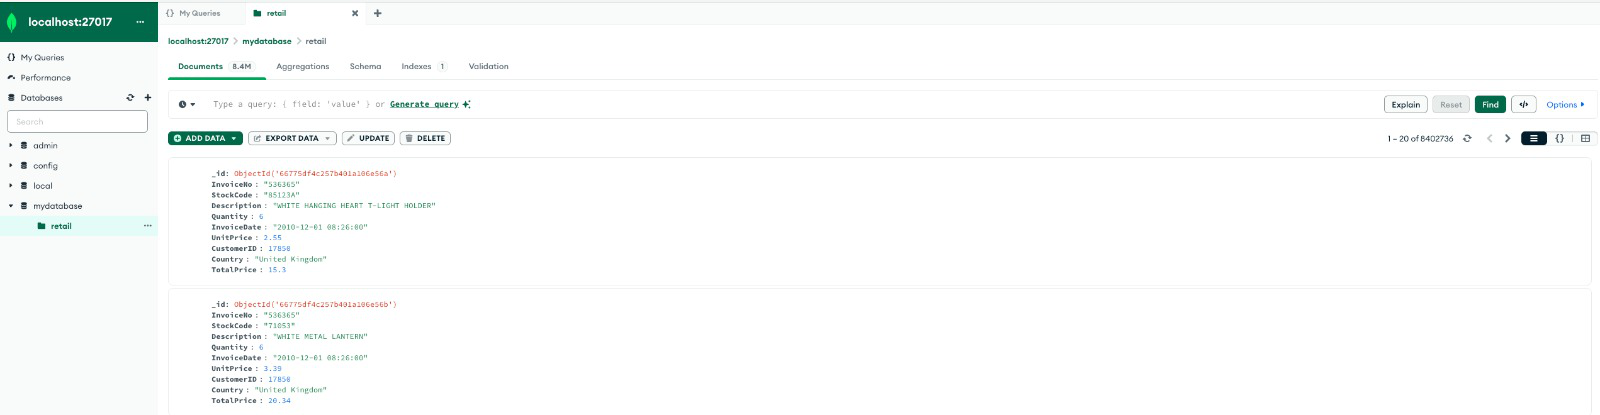

In [9]:
img = Image.open('mongodb.jpg')
display(img)

##### Email Operator

This task sends an email notification of the successful execution of the ETL pipeline.

The screengrab below displays the Airflow variable "emails" that is necessary to create.

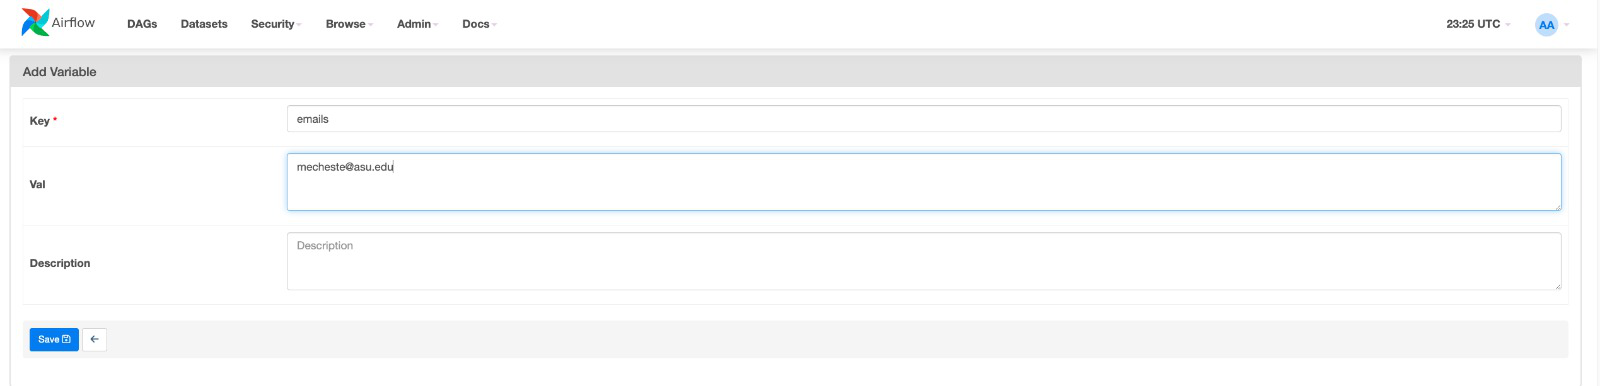

In [10]:
img = Image.open('emails variable.jpg')
display(img)

In [ ]:
# fetch the emails that will recieve the notification
emails = Variable.get("emails")
email_list = [value.strip() for value in emails.split(',')]

# summary email task
summary_email = EmailOperator(
    task_id='send_summary_email',
    to=email_list,
    subject='DAG {{ dag.dag_id }}: Summary',
    html_content="""
    <h3>Summary for DAG {{ dag.dag_id }}</h3>
    <p>The DAG {{ dag.dag_id }} has completed its run.</p>
    <p>Run details:</p>
    <ul>
        <li>Execution Date: {{ ds }}</li>
        <li>Start Date: {{ execution_date }}</li>
        <li>End Date: {{ next_execution_date }}</li>
    </ul>
    """,
    dag=dag
)

The format of the email summary that is sent can be seen below.

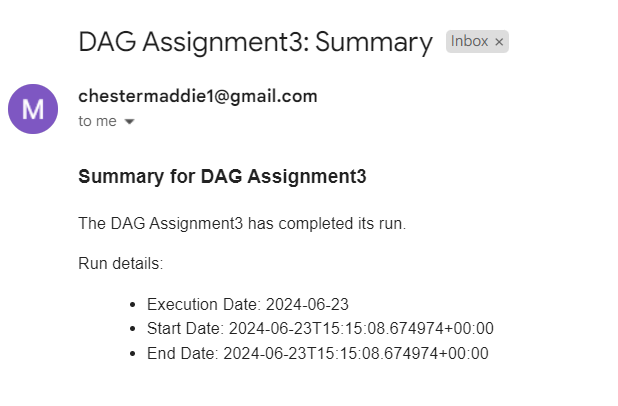

In [13]:
img = Image.open('email summary.png')
display(img)

##### DAG Structure and Scheduling

Here we define the flow of the tasks in the pipeline.

The schedule_interval argument is defined such that the pipeline executes daily.

In [ ]:
# defaults
default_args = {
    'owner': 'Madison',
    'depends_on_past': False,
    'start_date': datetime(2024, 5, 25),
    'email': email_list,
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=1)
}

dag = DAG('Assignment3', default_args=default_args, description="Big Data Assignment 3", schedule_interval=timedelta(days=1))

# tasks created using operators
t1 = PythonOperator(
    task_id='download_dataset',
    python_callable=download_dataset,
    dag=dag)

t2 = PythonOperator(
    task_id='data_cleaning',
    python_callable=data_cleaning,
    dag=dag)

t3 = PythonOperator(
    task_id='data_transformation',
    python_callable=data_transformation,
    dag=dag)

t4 = PythonOperator(
    task_id='data_to_nosql',
    python_callable=data_to_nosql,
    dag=dag)

#DAG
t1>>t2>>t3>>t4>>summary_email

The DAG schema generated by Airflow is as follows:

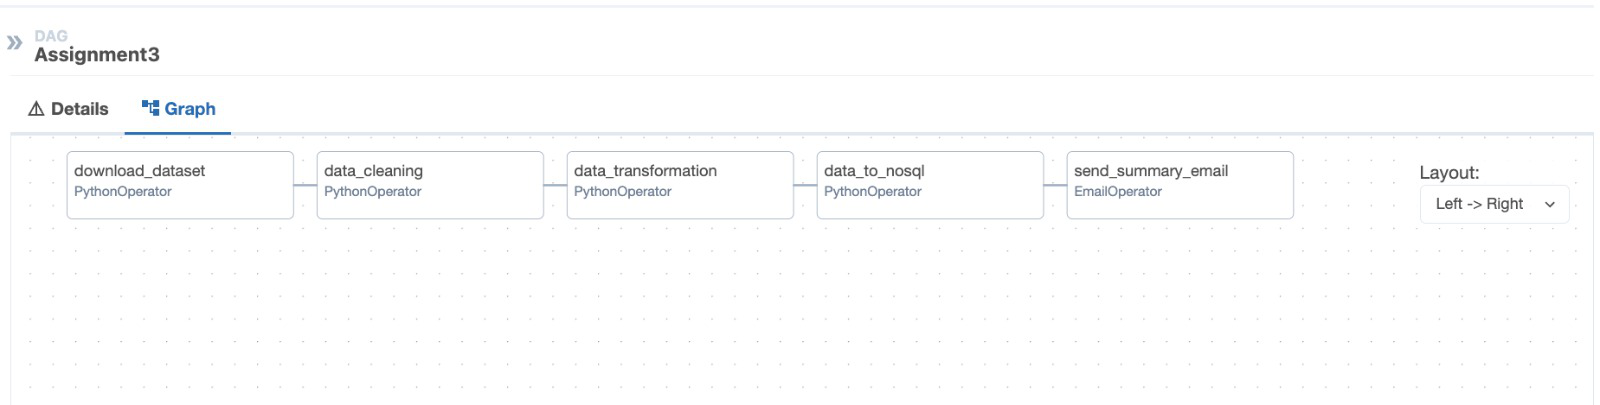

In [14]:
img = Image.open('schema.jpg')
display(img)

The complete task duration can be seen in the following image. 

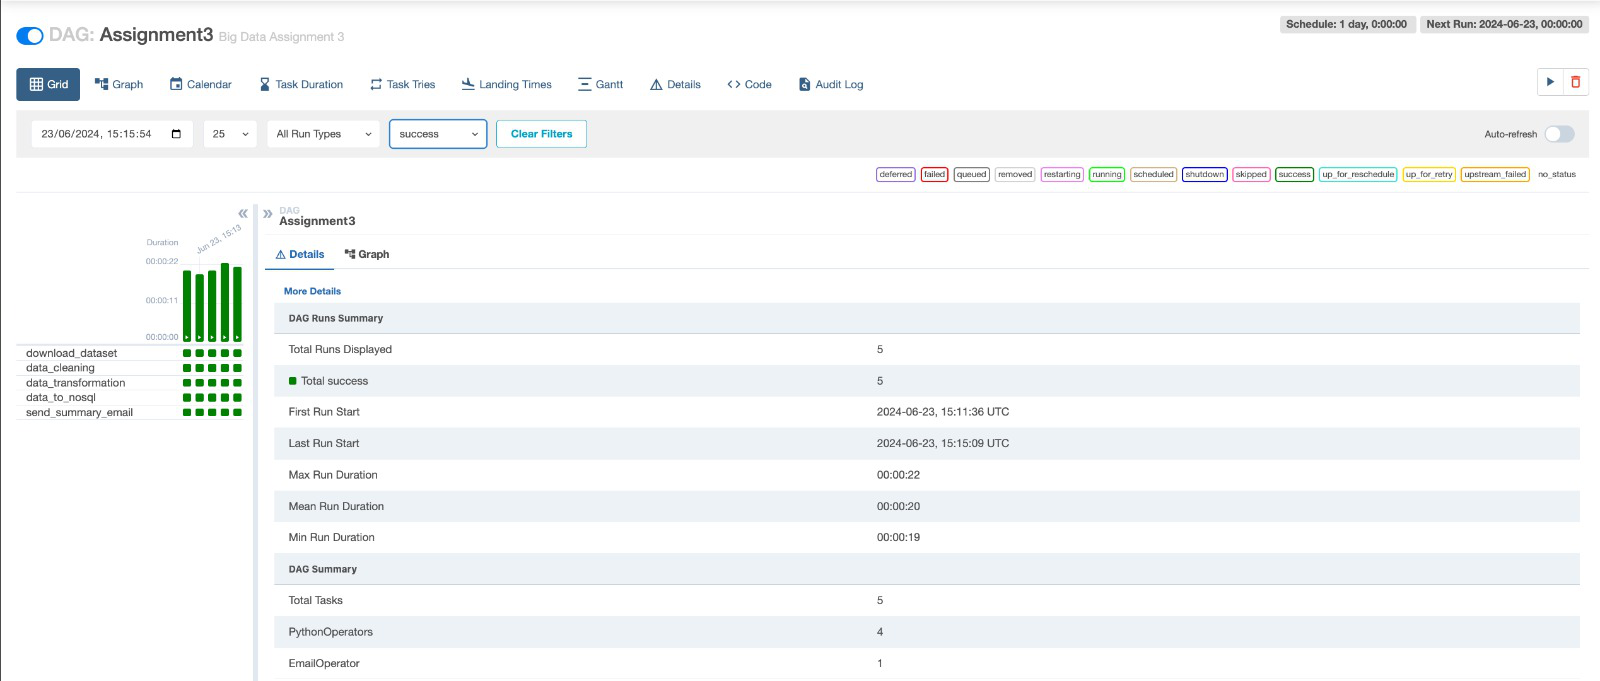

In [15]:
img = Image.open('task duration.jpg')
display(img)

##### Summary 

In this assignment, we built an ETL pipeline using Apache Airflow to process and prepare data for a machine learning model. The dataset used is the "Online Retail" dataset from the UCI Machine Learning Repository. The pipeline consists of several tasks, each contributing to the overall goal of data preparation. The download_dataset task fetches the dataset and saves it to a temporary folder, ensuring the data is accessible for subsequent steps. The data_cleaning task reads this data, converts the 'InvoiceDate' column to datetime, removes duplicates and null values, and saves the cleaned data. The data_transformation task adds a 'TotalPrice' column, representing the product of 'Quantity' and 'UnitPrice'. The data_to_nosql task loads the transformed data into a MongoDB collection, facilitating efficient storage and retrieval. Finally, an EmailOperator task sends a notification upon successful pipeline execution. The DAG structure, defined with dependencies between tasks, ensures an orderly execution of these processes, running daily as per the schedule. Each part of the pipeline is essential for transforming raw data into a cleaned and enriched format, ready for machine learning applications.